In [100]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Load specific forecasting tools
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [101]:
pd.set_option('display.max_rows', 2000)

In [102]:
df = pd.read_csv('final_con.csv',index_col='Date')
df

,Weekly U.S. Ending Stocks of Finished Motor Gasoline (Thousand Barrels),U.S. Gasoline Demand (Thousand Barrels per Day),Weekly U.S. Imports of Finished Motor Gasoline (Thousand Barrels per Day),Weekly U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon),Weekly U.S. Product Supplied of Finished Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Refiner and Blender Net Production of Finished Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Exports of Finished Motor Gasoline (Thousand Barrels per Day),Motor Gasoline Consumed by the Transportation Sector(T/ B per Day),Motor Gasoline Consumed by the Commercial Sector(T/ B per Day),Motor Gasoline Consumed by the Industrial Sector(T/ B per Day)
Date,,,,,,,,,,
1993-07-01,177380,7788,0,1.068667,7788.333333,7430,0,7671.122,16.073,97.481
1993-08-01,169446,7857,0,1.061500,7857.500000,7288,0,7749.086,16.236,98.471
1993-09-01,167090,7559,0,1.049500,7559.500000,7528,0,7496.345,15.706,95.260
1993-10-01,171262,7553,0,1.090200,7553.600000,7416,0,7274.525,15.242,92.441
1993-11-01,174098,7507,0,1.062000,7507.250000,7652,0,7422.855,15.552,94.326
1993-12-01,183614,7729,0,1.019000,7729.333333,7752,0,7549.658,15.818,95.937
1994-01-01,190179,6931,167,1.000000,6931.500000,7119,0,6875.377,12.131,92.569
1994-02-01,189954,7201,274,1.009000,7201.250000,6836,0,7165.776,12.644,96.479
1994-03-01,182302,7375,360,1.007750,7375.500000,6779,0,7284.018,12.852,98.071


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 1993-07-01 to 2019-08-01
Data columns (total 10 columns):
Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)                                 314 non-null int64
U.S. Gasoline Demand (Thousand Barrels per Day)                                                          314 non-null int64
Weekly U.S. Imports of Finished Motor Gasoline  (Thousand Barrels per Day)                               314 non-null int64
Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)                     314 non-null float64
Weekly U.S. Product Supplied of Finished Motor Gasoline  (Thousand Barrels per Day)                      314 non-null float64
Weekly U.S. Refiner and Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)    314 non-null int64
Weekly U.S. Exports of Finished Motor Gasoline  (Thousand Barrels per Day)                               314 non-null int64
Motor Gasoli

In [104]:
df.index.freq = 'H'

In [105]:
df_l = df[['Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)']]

In [106]:
len(df_l)

314

In [107]:
df_l.index.freq = '1H'

In [108]:
df_l = df_l.reset_index()

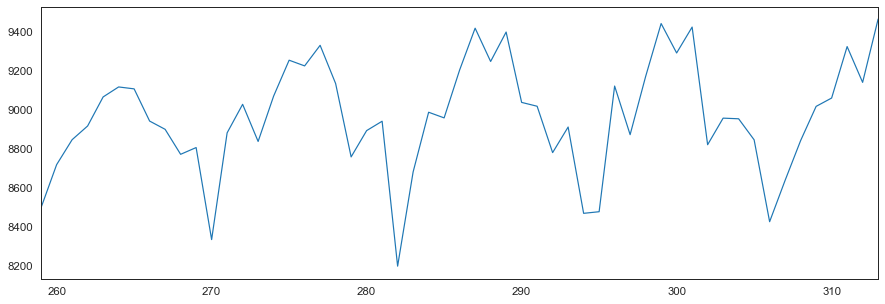

In [109]:
df_l[df_l.Date > '2015-01-01']['Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)'].plot(figsize=(15,5)).autoscale(axis='x',tight=True)

In [110]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [1]:
con=df_l[df_l.Date > '2015-01-01']['Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)']

NameError: name 'df_l' is not defined

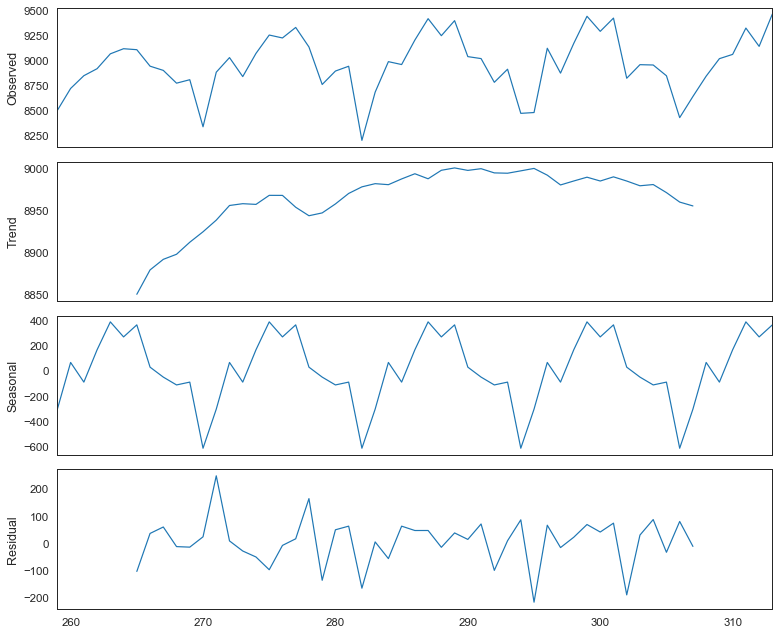

In [112]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(con, model='additive', freq=12)
fig = decomposition.plot()
plt.show()

In [173]:

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [174]:
adf_test(df_l['Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.706487
p-value                   0.072922
# lags used              14.000000
# observations          299.000000
critical value (1%)      -3.452411
critical value (5%)      -2.871255
critical value (10%)     -2.571947
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [175]:
l_df = len(df_l[df_l.Date >= '2012-01-01'])

In [176]:
l_split = len(df_l[df_l.Date >= '2018-01-01'])

In [177]:
train = df_l.iloc[:(l_df-l_split)]
test = df_l.iloc[(l_df-l_split):]

In [178]:
l_split

20

In [179]:
dataset = df_l['Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)'].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
train_size = l_df-l_split
test_size = len(dataset) - train_size
train, test = scaler.fit_transform(dataset[0:train_size,:]), scaler.transform(dataset[train_size:len(dataset),:])

In [180]:
l_df-l_split

72

In [181]:
train_size

72

In [182]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [183]:
len(train)

72

In [184]:
len(test)

242

In [185]:
# reshape into X=t and Y=t+1
look_back = 24
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [186]:
X_train.shape

(47, 24)

In [187]:
Y_train.shape

(47,)

In [188]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [189]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
opt = optimizers.Adam(lr=.001)
model.compile(loss='mean_squared_error', optimizer=opt)

history = model.fit(X_train, Y_train, epochs=29, batch_size=12, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 47 samples, validate on 217 samples
Epoch 1/29
47/47 [==============================] - 1s 14ms/step - loss: 0.2199 - val_loss: 0.2469
Epoch 2/29
47/47 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0241
Epoch 3/29
47/47 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.1397
Epoch 4/29
47/47 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 0.0862
Epoch 5/29
47/47 [==============================] - 0s 1ms/step - loss: 0.0438 - val_loss: 0.0191
Epoch 6/29
47/47 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0304
Epoch 7/29
47/47 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0244
Epoch 8/29
47/47 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0157
Epoch 9/29
47/47 [==============================] - 0s 1ms/step - loss: 0.0167 - val_loss: 0.0180
Epoch 10/29
47/47 [==============================] - 0s 1ms/step - loss:

In [190]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

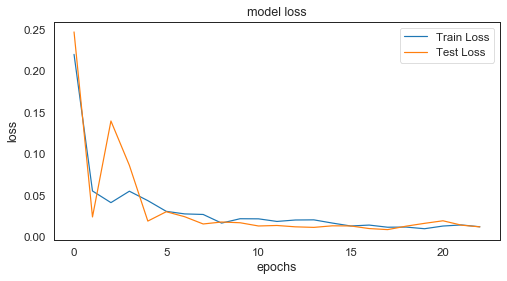

In [191]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

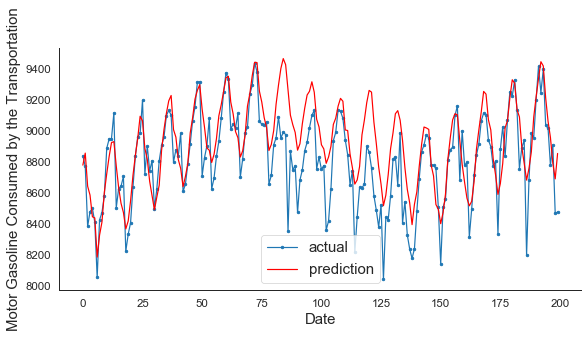

In [192]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Motor Gasoline Consumed by the Transportation', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show();

In [193]:
df_l = df_l.set_index('Date')

In [194]:
Y_test.shape

(1, 217)

In [195]:
test_predict.shape

(217, 1)

In [196]:
Y_train.shape

(1, 47)

In [197]:
-(look_back*2+2)

-50

In [198]:
tes = pd.DataFrame(Y_test.reshape(Y_test.shape[1],Y_test.shape[0]) , columns=['test'] , 
                   index= df_l.iloc[train_size+look_back:-1].index)

In [199]:
pre = pd.DataFrame(test_predict , columns=['pred'] , index= df_l.iloc[train_size+look_back:-1].index)

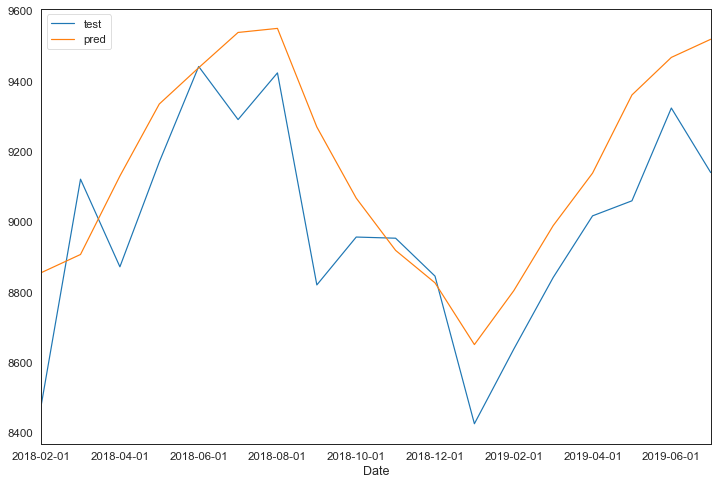

In [200]:
tes.test['2018-01-01 00:00:00':].plot(legend=True, figsize=(12,8))
pre.pred['2018-01-01 00:00:00':].plot(legend=True)

In [201]:
rmse(tes.test , pre.pred)

210.84245471552856

In [202]:
tes.test.mean()

8829.401831706024

In [203]:
pre.pred.mean()

8943.48046875